Entire file executed in anaconda with tf-cpu environment. 

Required Hardware Configuration - NVIDIA® GPU card with CUDA® Compute Capability 3.5 or higher

Required Software Configuration-
    NVIDIA® GPU drivers —CUDA 10.1 requires 418.x or higher.
    CUDA® Toolkit —TensorFlow supports CUDA 10.1 (TensorFlow >= 2.1.0)
    CUPTI ships with the CUDA Toolkit.
    cuDNN SDK (>= 7.6)

tf environment comes with tensorflow, but other files libraries like keras, matplotlib, plotly, sklearn, pillow needs to be installed before executing this code. 


In [33]:

import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import optimizers


DataSet is created in two ways.

Step 1:     Fruits and Vegetables video captured in different location, quantity, pattern and lighting condition
            Fruits and Vegetables video ( 3-4 minute videos for every fruit or vegetable) converted into images with different             frame rate.
            
             24 Classes
            
             Train, Valid and Test set considered
            
             frame rate is set to 0.15 for train, 0.33 for valid and 0.42 for test. These frame rate changed multiple times
            
             Now all classes in train is limited to 800 by deleteling extra images in random order. Similarly test and valid                limited to 320
  
Step 2:     Random respective fruit and vegetable images (5-10) were downloaded from internet to all the classes and used                   keras image augmentation function to create 100 -200 images in total.
            Again, all classes in train cut down to 800, and valid and test to 320 images.


So final dataset has diverse images in all three train, valid and test.

            
 



Set train, valid and test path

load train and valid set files

In [34]:
train_path = 'C:/Users/Owner/Desktop/Produce Item Recognition/DataSet/TrainSet/'
valid_path = 'C:/Users/Owner/Desktop/Produce Item Recognition/DataSet/ValidationSet/'
test_path = 'C:/Users/Owner/Desktop/Produce Item Recognition/DataSet/TestSet/'


train_image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

Class distribution in train and validation set

In [35]:
import os

entries = os.listdir(train_path)
folders = glob(train_path + '/*')

train_class_dist={}  #dictionary to store train class distribution 
count=0
for folder in folders:
  number_of_images=glob(folder+'/*.jp*g')
  train_class_dist[entries[count]]=len(number_of_images)
  count+=1

valid_entries = os.listdir(valid_path)
valid_folders = glob(valid_path + '/*')
valid_class_dist={} #dictionary to valid class distribution
count=0
for folder in valid_folders:
  valid_number_of_images=glob(folder+'/*.jp*g')
  valid_class_dist[entries[count]]=len(valid_number_of_images)
  count+=1



Plot Train dataset class distribution

In [36]:
import plotly.express as px

fig = px.bar(train_class_dist.keys(), x=list(train_class_dist.keys()), y=list(train_class_dist.values()),
             labels={"y":"Class Size", "x":"Fruits and Vegetables"},title="Train DataSet")
fig.update_traces(texttemplate='%{y:.2s}', textposition='outside')

fig.show()

Plot Validation dataset class distribution

In [37]:

import plotly.express as px

fig = px.bar(valid_class_dist.keys(), x=list(valid_class_dist.keys()), y=list(valid_class_dist.values()),labels={"y":"Class Size", "x":"Fruits and Vegetables"},title="Validation DataSet")
fig.update_traces(texttemplate='%{y:.2s}', textposition='outside')

fig.show()

Image input shape, epochs and batch size

In [38]:
IMAGE_SIZE = [100, 100]
epochs = 50
train_batch_size =16
valid_batch_size=8
test_batch_size=8


Augmention only with rescle

In [39]:
gen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    #rotation_range=10,
    #shear_range=0.2,
    #zoom_range=0.2,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip=True,
    #vertical_flip=True,
    
)

test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k



Found 7680 images belonging to 24 classes.
{'Apple': 0, 'Avocado': 1, 'Banana': 2, 'Blueberry': 3, 'Brocolli': 4, 'Cabbage': 5, 'Canada Pear': 6, 'Carrot': 7, 'Garlic': 8, 'Green Peas': 9, 'Green Pepper': 10, 'Lettuce': 11, 'Mangoes': 12, 'Okra': 13, 'Orange': 14, 'Pineapple': 15, 'Red Chilli': 16, 'Red Onions': 17, 'Spinach': 18, 'Spring Onion': 19, 'Tomato': 20, 'Yellow Onion': 21, 'Yellow Potato': 22, 'bell pepper': 23}


Display augmented images

Found 19181 images belonging to 24 classes.


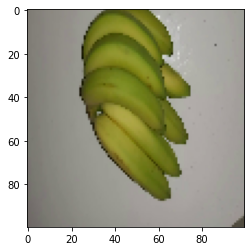

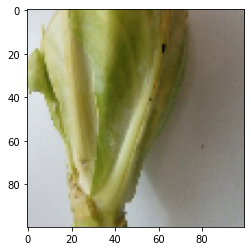

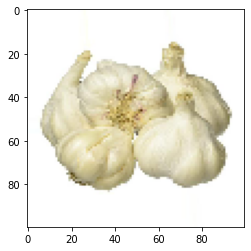

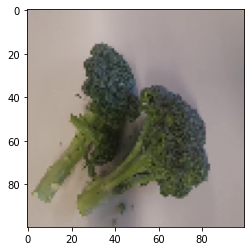

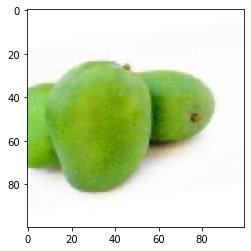

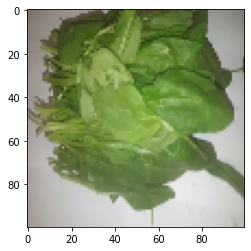

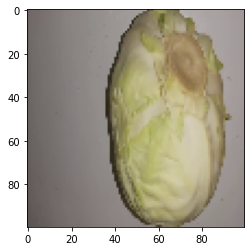

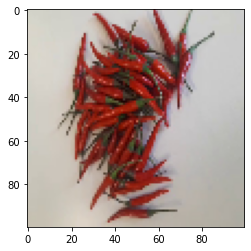

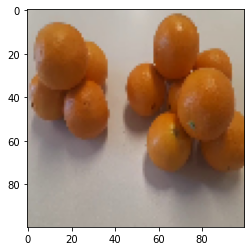

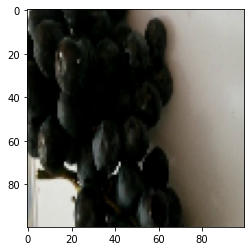

In [40]:
tgr = gen.flow_from_directory(
    train_path,
    color_mode = "rgb",
    target_size=(100,100),
    batch_size=1,
    class_mode=None)


i = 0
img_list = []
for batch in tgr:
    img_list.append(batch)
    i += 1
    if i > 9:
        break
        

for img in img_list:
    plt.imshow(np.squeeze(img))
    plt.show()

train generator with shuffle =True and seed =42

Valid and test gerators are not shuffle and no seed

In [41]:
train_generator = gen.flow_from_directory(
  train_path,
  color_mode = "rgb",
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=train_batch_size,
  seed=42,
    
)
valid_generator = gen.flow_from_directory(
  valid_path,
  color_mode = "rgb",
  target_size=IMAGE_SIZE,
  shuffle=False,
  batch_size=valid_batch_size,
  
)
test_generator = gen.flow_from_directory(
  test_path,
  color_mode = "rgb",
  target_size=IMAGE_SIZE,
  shuffle=False,
  
)

Found 19181 images belonging to 24 classes.
Found 7680 images belonging to 24 classes.
Found 7680 images belonging to 24 classes.


Load Vgg16 on imagenet

In [42]:
base_model=VGG16(weights='imagenet',include_top=False, input_shape=(100,100,3))

Squential model

In [43]:
from keras.applications import VGG16
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(24, activation='softmax'))


In [44]:
model=Model(inputs=base_model.input, outputs=top_model(base_model.output))

In [45]:
for layer in model.layers[:15]:
    layer.trainable = False

Complie with SGD optimizer and LR =le-4 and momentum=0.9

In [46]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print('Compiled!')

Compiled!


Train model with earlystop and model check point

In [47]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("C:/Users/Owner/Desktop/Produce Item Recognition/vgg16.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=1, mode='auto')

r=model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  callbacks=[early,checkpoint],
  steps_per_epoch=len(train_image_files) // train_batch_size,
  validation_steps=len(valid_image_files) //valid_batch_size,
 
  
)


Epoch 1/50
1198/1198 [==============================] - 542s 452ms/step - loss: 1.0933 - accuracy: 0.7595 - val_loss: 0.2627 - val_accuracy: 0.9559

Epoch 00001: val_accuracy improved from -inf to 0.95586, saving model to C:/Users/Owner/Desktop/Produce Item Recognition/vgg16.h5
Epoch 2/50
1198/1198 [==============================] - 529s 441ms/step - loss: 0.6337 - accuracy: 0.9471 - val_loss: 0.0000e+00 - val_accuracy: 0.9810

Epoch 00002: val_accuracy improved from 0.95586 to 0.98099, saving model to C:/Users/Owner/Desktop/Produce Item Recognition/vgg16.h5
Epoch 3/50
1198/1198 [==============================] - 539s 450ms/step - loss: 0.5849 - accuracy: 0.9662 - val_loss: 4.1269e-05 - val_accuracy: 0.9822

Epoch 00003: val_accuracy improved from 0.98099 to 0.98216, saving model to C:/Users/Owner/Desktop/Produce Item Recognition/vgg16.h5
Epoch 4/50
1198/1198 [==============================] - 505s 422ms/step - loss: 0.6051 - accuracy: 0.9719 - val_loss: 0.0000e+00 - val_accuracy: 0.99

Saving the model

In [48]:
model.save("vgg16_5.h5")

train vs validation loss graph

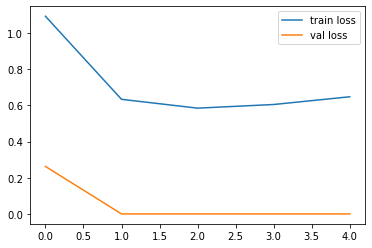

In [49]:

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')

plt.legend()
plt.show()

train vs validation accuracy graph

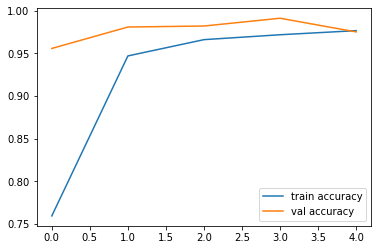

In [50]:

plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

Load model 

In [51]:
model = load_model('vgg16_5.h5')

In [52]:
model.compile(loss='categorical_crossentropy',
     optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
     metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

Test with test data

In [53]:
test_image_files = glob(test_path + '/*/*.jp*g')

In [54]:
predictions = model.predict_generator(test_generator)



In [55]:
print(len(predictions))

7680


In [56]:
len(test_generator.classes)

7680

Classification Report

In [57]:
import numpy
import sklearn.metrics as metrics
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_generator.classes
print(len(predictions), len(true_classes),len(test_image_files))

class_labels = list(test_generator.class_indices.keys()) 

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

7680 7680 7680
               precision    recall  f1-score   support

        Apple       0.97      0.95      0.96       320
      Avocado       0.99      1.00      1.00       320
       Banana       1.00      1.00      1.00       320
    Blueberry       1.00      0.97      0.98       320
     Brocolli       0.98      0.97      0.98       320
      Cabbage       1.00      0.77      0.87       320
  Canada Pear       0.98      0.99      0.98       320
       Carrot       1.00      1.00      1.00       320
       Garlic       1.00      0.97      0.99       320
   Green Peas       0.94      1.00      0.97       320
 Green Pepper       1.00      1.00      1.00       320
      Lettuce       0.99      1.00      1.00       320
      Mangoes       0.84      0.98      0.91       320
         Okra       1.00      1.00      1.00       320
       Orange       1.00      0.99      1.00       320
    Pineapple       0.99      0.99      0.99       320
   Red Chilli       1.00      1.00      1.00     

Confusion Matrix

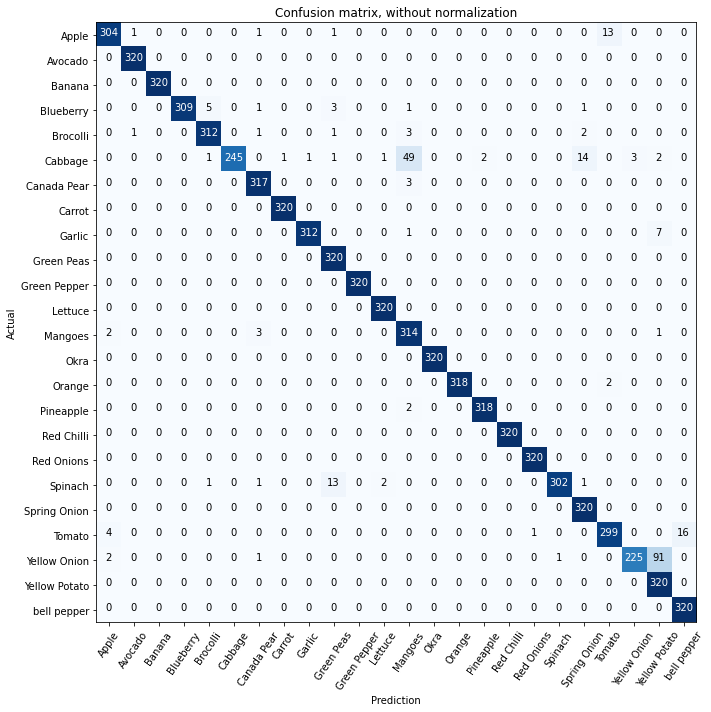

In [58]:

from sklearn.metrics import classification_report, confusion_matrix
import itertools

cm=confusion_matrix(test_generator.classes, predicted_classes)
classes=class_labels
np.set_printoptions(precision=2)
plt.figure(figsize=(15,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix, without normalization')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=55)
plt.yticks(tick_marks, classes)
normalize=False
fmt ='d'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tight_layout()

In [59]:
IMAGE_SIZE=[100,100]
def load_image(image_path):
    img = image.load_img(image_path, target_size=IMAGE_SIZE)
    return img

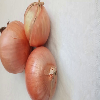

In [60]:
image_path="C:/Users/Owner/Desktop/Produce Item Recognition/DataSet/TestSet/Yellow Onion/image1.jpg"
img=load_image(image_path)
img


In [61]:
 def getImages(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    return images


In [62]:
images=getImages(img)
predict_result={}
def predict_image(images):
    classes = model.predict(images)
    a=classes.tolist()
    for i in a[0]:
      if i>0.002:
        pos=a[0].index(i)
        val=i
        for label in test_gen_class_indices.keys():
          if test_gen_class_indices[label]==pos:
            predict_result[label]=val
    return predict_result

In [63]:
test_gen_class_indices={'Apple': 0, 'Avocado': 1, 'Banana': 2, 'Blueberry': 3, 'Brocolli': 4, 'Cabbage': 5, 'Canada Pear': 6, 'Carrot': 7, 'Garlic': 8, 'Green Peas': 9, 'Green Pepper': 10, 'Lettuce': 11, 'Mangoes': 12, 'Okra': 13, 'Orange': 14, 'Pineapple': 15, 'Red Chilli': 16, 'Red Onions': 17, 'Spinach': 18, 'Spring Onion': 19, 'Tomato': 20, 'Yellow Onion': 21, 'Yellow Potato': 22, 'bell pepper': 23}
prediction=predict_image(images)
for key in prediction.keys():
    print('%s (%.2f%%)' % (key, prediction[key]*100))

Yellow Onion (100.00%)


In the below section, we are taking random 1000 images from test from every class, here images might repeat. We use predict function to predict.

Finally caluclate how many images predicted correctly for every class

In [64]:
Dir=list(test_gen_class_indices.keys())
final_result={}
for item in Dir:
    print(final_result)
    path=test_path+item+"/"
    image_files = glob(path + '*.jp*g')
    
    perc=0
    for i in range(1000):
      imgfile=np.random.choice(image_files)
      img = image.load_img(imgfile, target_size=(100,100))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      images = np.vstack([x])

      classes = model.predict(images)

      a=classes.tolist()

      for i in a[0]:
        if i>=0.7:
          pos=a[0].index(i)
          val=i
      
      for j in test_gen_class_indices.keys():
        if test_gen_class_indices[j]==pos:
         
          if j==item:
            perc=perc+1
        
    
    
    final_result[item]=(perc/1000*100)
   

{}
{'Apple': 94.89999999999999}
{'Apple': 94.89999999999999, 'Avocado': 79.5}
{'Apple': 94.89999999999999, 'Avocado': 79.5, 'Banana': 100.0}
{'Apple': 94.89999999999999, 'Avocado': 79.5, 'Banana': 100.0, 'Blueberry': 72.5}
{'Apple': 94.89999999999999, 'Avocado': 79.5, 'Banana': 100.0, 'Blueberry': 72.5, 'Brocolli': 26.3}
{'Apple': 94.89999999999999, 'Avocado': 79.5, 'Banana': 100.0, 'Blueberry': 72.5, 'Brocolli': 26.3, 'Cabbage': 13.700000000000001}
{'Apple': 94.89999999999999, 'Avocado': 79.5, 'Banana': 100.0, 'Blueberry': 72.5, 'Brocolli': 26.3, 'Cabbage': 13.700000000000001, 'Canada Pear': 100.0}
{'Apple': 94.89999999999999, 'Avocado': 79.5, 'Banana': 100.0, 'Blueberry': 72.5, 'Brocolli': 26.3, 'Cabbage': 13.700000000000001, 'Canada Pear': 100.0, 'Carrot': 95.19999999999999}
{'Apple': 94.89999999999999, 'Avocado': 79.5, 'Banana': 100.0, 'Blueberry': 72.5, 'Brocolli': 26.3, 'Cabbage': 13.700000000000001, 'Canada Pear': 100.0, 'Carrot': 95.19999999999999, 'Garlic': 9.5}
{'Apple': 94.8

In [26]:
import plotly.express as px

fig = px.bar(final_result.keys(), x=list(final_result.keys()), y=list(final_result.values()),labels={"y":"Pass Percentage", "x":"Fruits and Vegetables"},title="Final Prediction Report- 1000 samples per Class")
fig.update_traces(texttemplate='%{y:.2s}', textposition='outside')

fig.show()